# Add Advanced Features for LSTM

This notebook adds 10 advanced technical and temporal features to the LSTM-ready data:
- Cyclical time encoding (4 features)
- Market state indicators (1 feature)
- Price returns (2 features)
- Volatility measures (1 feature)
- Technical momentum (1 feature)
- Volume analysis (1 feature)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Tuple

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load LSTM-age-added Data

In [2]:
# Load the data with age features
data_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_df = pd.read_parquet(os.path.join(data_dir, "HBEA_LSTM_age_added.parquet"))
gdea_df = pd.read_parquet(os.path.join(data_dir, "GDEA_LSTM_age_added.parquet"))

print(f"HBEA shape: {hbea_df.shape}")
print(f"GDEA shape: {gdea_df.shape}")
print(f"\nData range: {hbea_df.index.min()} to {hbea_df.index.max()}")
print(f"\nSample columns (first 10): {list(hbea_df.columns[:10])}")

HBEA shape: (4027, 42)
GDEA shape: (3967, 42)

Data range: 2014-04-28 00:00:00 to 2025-05-06 00:00:00

Sample columns (first 10): ['close', 'vwap', 'volume_tons', 'turnover_cny', 'cum_turnover_cny', 'is_open', 'is_quiet', 'has_trade', 'Hubei_ElectricityConsumption_Monthly_ffill_daily_15', 'Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15']


## 2. Verify Data Structure

In [3]:
# Understand the trading flags
print("=== Trading Flags Analysis ===")
print(f"has_trade value counts:\n{hbea_df['has_trade'].value_counts()}")
print(f"\nis_open value counts:\n{hbea_df['is_open'].value_counts()}")
print(f"\nis_quiet value counts:\n{hbea_df['is_quiet'].value_counts()}")

# Verify relationships
quiet_days = hbea_df[hbea_df['is_quiet'] == True]
print(f"\nQuiet days check:")
print(f"  All quiet days have is_open=True: {(quiet_days['is_open'] == True).all()}")
print(f"  All quiet days have has_trade=False: {(quiet_days['has_trade'] == False).all()}")

=== Trading Flags Analysis ===
has_trade value counts:
has_trade
True     2610
False    1417
Name: count, dtype: int64

is_open value counts:
is_open
True     2679
False    1348
Name: count, dtype: int64

is_quiet value counts:
is_quiet
False    3958
True       69
Name: count, dtype: int64

Quiet days check:
  All quiet days have is_open=True: True
  All quiet days have has_trade=False: True


## 3. Feature Engineering Functions

In [4]:
def add_cyclical_time_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add cyclical encoding for day of week and month.
    """
    df = df.copy()
    
    # Day of week encoding (0=Monday, 6=Sunday)
    df['dow_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
    
    # Month encoding (1-12 mapped to 0-11 for calculation)
    df['month_sin'] = np.sin(2 * np.pi * (df.index.month - 1) / 12)
    df['month_cos'] = np.cos(2 * np.pi * (df.index.month - 1) / 12)
    
    return df


def add_market_state_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add days_since_trade feature to track market inactivity.
    """
    df = df.copy()
    
    # Create groups that increment when trading occurs
    trade_event = df['has_trade'].astype(int)
    trade_groups = trade_event.cumsum()
    
    # Count days within each group
    days_counter = df.groupby(trade_groups).cumcount()
    
    # Only count non-trading days (when has_trade=False)
    df['days_since_trade'] = days_counter * (~df['has_trade']).astype(int)
    
    return df


def add_return_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add log returns and 5-day returns.
    """
    df = df.copy()
    
    # Daily log returns
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # 5-day percentage returns
    df['return_5d'] = df['close'].pct_change(5)
    
    return df


def add_volatility_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Bollinger Band width as volatility measure.
    """
    df = df.copy()
    
    # 20-day rolling statistics
    sma20 = df['close'].rolling(20, min_periods=1).mean()
    std20 = df['close'].rolling(20, min_periods=1).std()
    
    # Bollinger bands
    upper_band = sma20 + 2 * std20
    lower_band = sma20 - 2 * std20
    
    # Normalized width (handle division by zero)
    df['bb_width'] = (upper_band - lower_band) / sma20.replace(0, np.nan)
    
    return df


def add_momentum_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add RSI (Relative Strength Index) indicator.
    """
    df = df.copy()
    
    # Calculate price changes
    delta = df['close'].diff()
    
    # Separate gains and losses
    gain = delta.clip(lower=0)
    loss = (-delta.clip(upper=0))
    
    # Use exponential weighted mean (Wilder's smoothing)
    # For 14-day RSI, use com=13 (equivalent to alpha=1/14)
    avg_gain = gain.ewm(com=13, adjust=False, min_periods=14).mean()
    avg_loss = loss.ewm(com=13, adjust=False, min_periods=14).mean()
    
    # Calculate RSI
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df['rsi_14'] = 100 - (100 / (1 + rs))
    
    return df


def add_volume_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add volume moving average.
    """
    df = df.copy()
    
    # 20-day simple moving average of volume
    df['volume_sma_20'] = df['volume_tons'].rolling(20, min_periods=1).mean()
    
    return df

## 4. Apply All Feature Engineering

In [5]:
def add_all_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply all feature engineering functions in sequence.
    """
    print("Adding cyclical time features...")
    df = add_cyclical_time_features(df)
    
    print("Adding market state features...")
    df = add_market_state_features(df)
    
    print("Adding return features...")
    df = add_return_features(df)
    
    print("Adding volatility features...")
    df = add_volatility_features(df)
    
    print("Adding momentum features...")
    df = add_momentum_features(df)
    
    print("Adding volume features...")
    df = add_volume_features(df)
    
    return df

# Process both datasets
print("Processing HBEA data...")
hbea_advanced = add_all_advanced_features(hbea_df)

print("\nProcessing GDEA data...")
gdea_advanced = add_all_advanced_features(gdea_df)

print(f"\nFinal shapes:")
print(f"HBEA: {hbea_advanced.shape}")
print(f"GDEA: {gdea_advanced.shape}")

Processing HBEA data...
Adding cyclical time features...
Adding market state features...
Adding return features...
Adding volatility features...
Adding momentum features...
Adding volume features...

Processing GDEA data...
Adding cyclical time features...
Adding market state features...
Adding return features...
Adding volatility features...
Adding momentum features...
Adding volume features...

Final shapes:
HBEA: (4027, 52)
GDEA: (3967, 52)


## 5. Quality Checks

In [6]:
# List new features
new_features = [
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'days_since_trade', 'log_return', 'return_5d',
    'bb_width', 'rsi_14', 'volume_sma_20'
]

print("=== Quality Checks ===")
print("\n1. Cyclical features range check:")
for feat in ['dow_sin', 'dow_cos', 'month_sin', 'month_cos']:
    min_val = hbea_advanced[feat].min()
    max_val = hbea_advanced[feat].max()
    print(f"  {feat}: min={min_val:.3f}, max={max_val:.3f} (should be in [-1, 1])")

print("\n2. Days since trade check:")
# Check if it resets to 0 when trading occurs
trading_days = hbea_advanced[hbea_advanced['has_trade'] == True]['days_since_trade']
print(f"  All trading days have days_since_trade=0: {(trading_days == 0).all()}")
print(f"  Max days_since_trade: {hbea_advanced['days_since_trade'].max()}")

print("\n3. RSI bounds check:")
rsi_vals = hbea_advanced['rsi_14'].dropna()
print(f"  RSI range: {rsi_vals.min():.2f} to {rsi_vals.max():.2f} (should be in [0, 100])")

print("\n4. NaN counts for new features:")
for feat in new_features:
    nan_count = hbea_advanced[feat].isna().sum()
    print(f"  {feat}: {nan_count} NaNs")

=== Quality Checks ===

1. Cyclical features range check:
  dow_sin: min=-0.975, max=0.975 (should be in [-1, 1])
  dow_cos: min=-0.901, max=1.000 (should be in [-1, 1])
  month_sin: min=-1.000, max=1.000 (should be in [-1, 1])
  month_cos: min=-1.000, max=1.000 (should be in [-1, 1])

2. Days since trade check:
  All trading days have days_since_trade=0: True
  Max days_since_trade: 59

3. RSI bounds check:
  RSI range: 0.00 to 97.30 (should be in [0, 100])

4. NaN counts for new features:
  dow_sin: 0 NaNs
  dow_cos: 0 NaNs
  month_sin: 0 NaNs
  month_cos: 0 NaNs
  days_since_trade: 0 NaNs
  log_return: 1 NaNs
  return_5d: 5 NaNs
  bb_width: 1 NaNs
  rsi_14: 14 NaNs
  volume_sma_20: 0 NaNs


## 6. Verify Days Since Trade Logic

In [7]:
# Sample period to verify days_since_trade calculation
sample_cols = ['close', 'volume_tons', 'has_trade', 'is_open', 'days_since_trade']
sample_period = hbea_advanced[sample_cols].iloc[100:120]

print("Sample of days_since_trade calculation:")
print(sample_period)
print("\nNote: days_since_trade should:")
print("  - Be 0 when has_trade=True")
print("  - Increment on consecutive non-trading days")
print("  - Reset to 0 when trading resumes")

Sample of days_since_trade calculation:
            close  volume_tons  has_trade  is_open  days_since_trade
date                                                                
2014-08-06  23.06      28205.0       True     True                 0
2014-08-07  23.05      16439.0       True     True                 0
2014-08-08  23.05      16181.0       True     True                 0
2014-08-09  23.05          0.0      False    False                 1
2014-08-10  23.05          0.0      False    False                 2
2014-08-11  23.00       9537.0       True     True                 0
2014-08-12  22.54      13226.0       True     True                 0
2014-08-13  23.00      11443.0       True     True                 0
2014-08-14  22.53       6524.0       True     True                 0
2014-08-15  22.85      39298.0       True     True                 0
2014-08-16  22.85          0.0      False    False                 1
2014-08-17  22.85          0.0      False    False             

## 7. Feature Statistics

In [8]:
# Generate summary statistics for new features
stats_df = hbea_advanced[new_features].describe()
print("=== New Feature Statistics (HBEA) ===")
print(stats_df.round(3))

=== New Feature Statistics (HBEA) ===
        dow_sin   dow_cos  month_sin  month_cos  days_since_trade  log_return  \
count  4027.000  4027.000   4027.000   4027.000          4027.000    4026.000   
mean      0.000     0.000     -0.001     -0.005             1.145       0.000   
std       0.707     0.707      0.708      0.707             4.299       0.022   
min      -0.975    -0.901     -1.000     -1.000             0.000      -0.197   
25%      -0.782    -0.901     -0.500     -0.866             0.000      -0.003   
50%       0.000    -0.223      0.000     -0.000             0.000       0.000   
75%       0.782     0.623      0.866      0.500             1.000       0.002   
max       0.975     1.000      1.000      1.000            59.000       0.111   

       return_5d  bb_width    rsi_14  volume_sma_20  
count   4022.000  4026.000  4013.000       4027.000  
mean       0.002     0.108    50.337      24744.630  
std        0.047     0.103    13.343      36448.259  
min       -0.372

## 8. Visualizations

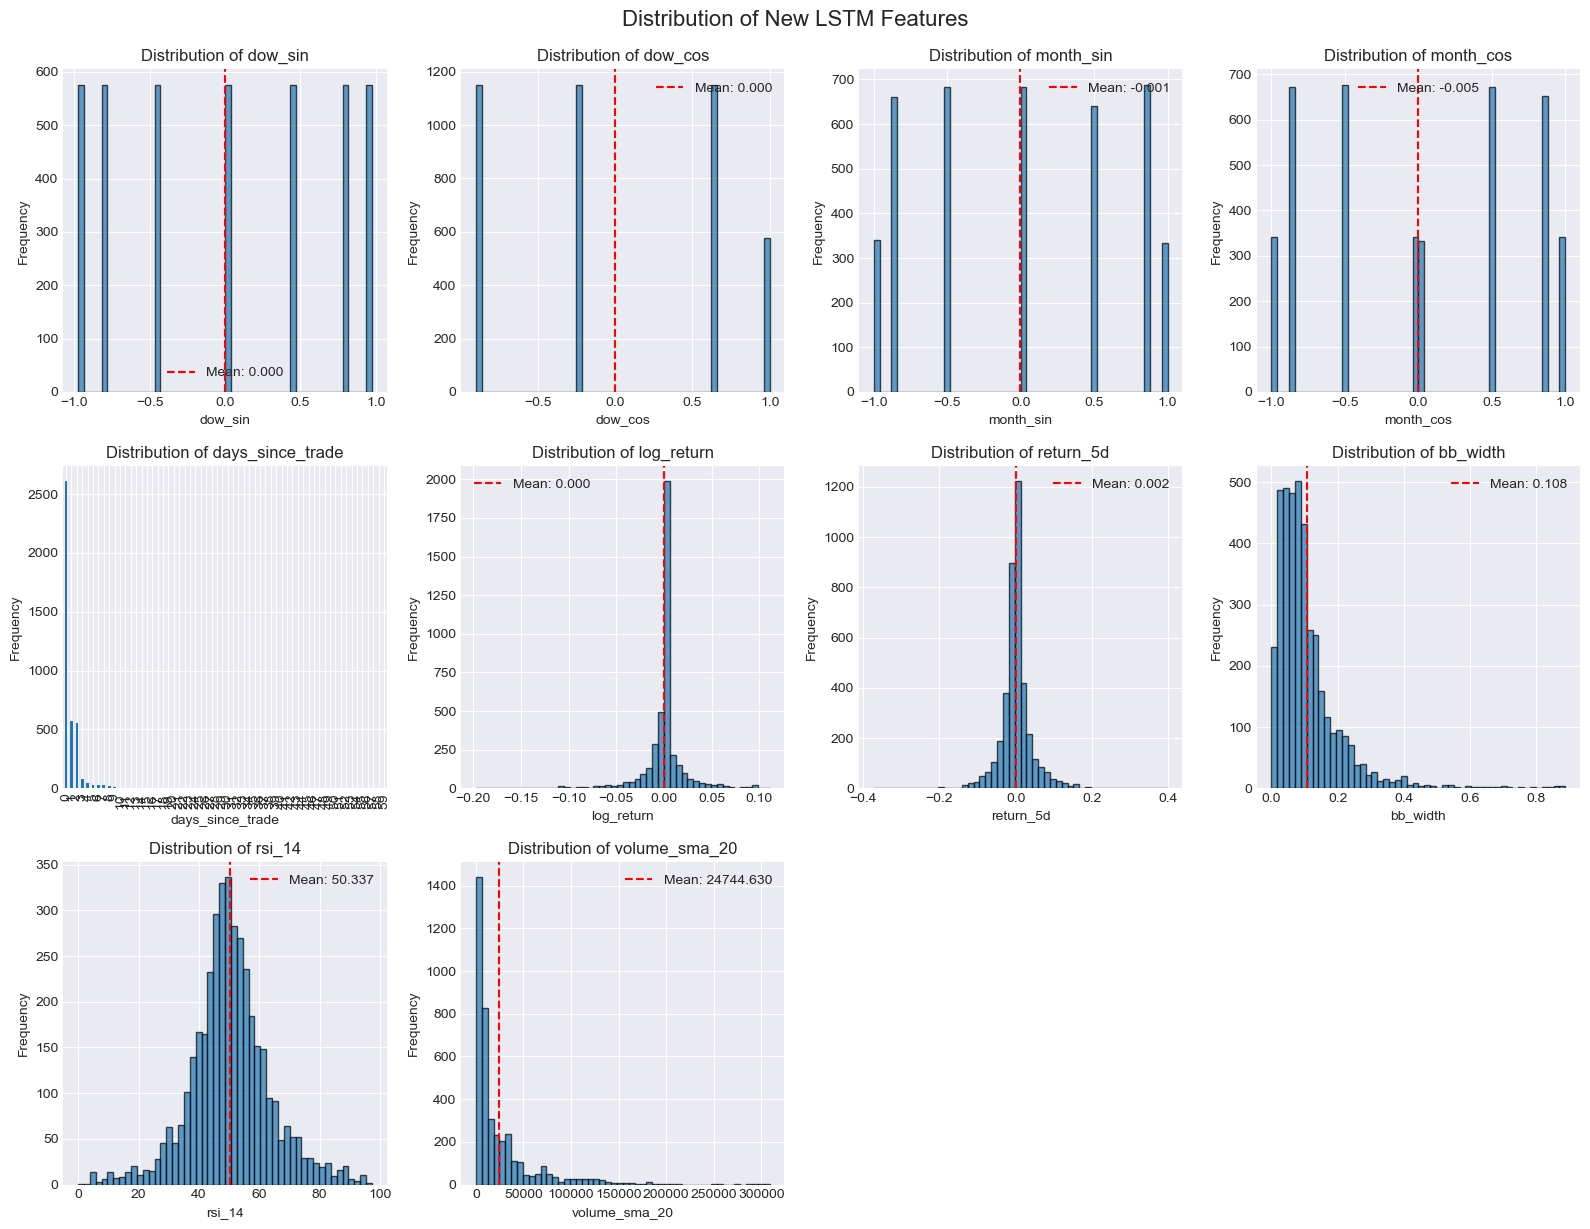

In [9]:
# Create visualizations for new features
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, feat in enumerate(new_features):
    ax = axes[idx]
    data = hbea_advanced[feat].dropna()
    
    if feat == 'days_since_trade':
        # Use bar plot for discrete values
        data.value_counts().sort_index().plot(kind='bar', ax=ax)
        ax.set_title(f'Distribution of {feat}')
        ax.set_xlabel(feat)
        ax.set_ylabel('Frequency')
    else:
        # Use histogram for continuous values
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribution of {feat}')
        ax.set_xlabel(feat)
        ax.set_ylabel('Frequency')
        ax.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.3f}')
        ax.legend()

# Remove empty subplots
for idx in range(len(new_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.suptitle('Distribution of New LSTM Features', y=1.02, fontsize=16)
plt.show()

## 9. Correlation Analysis

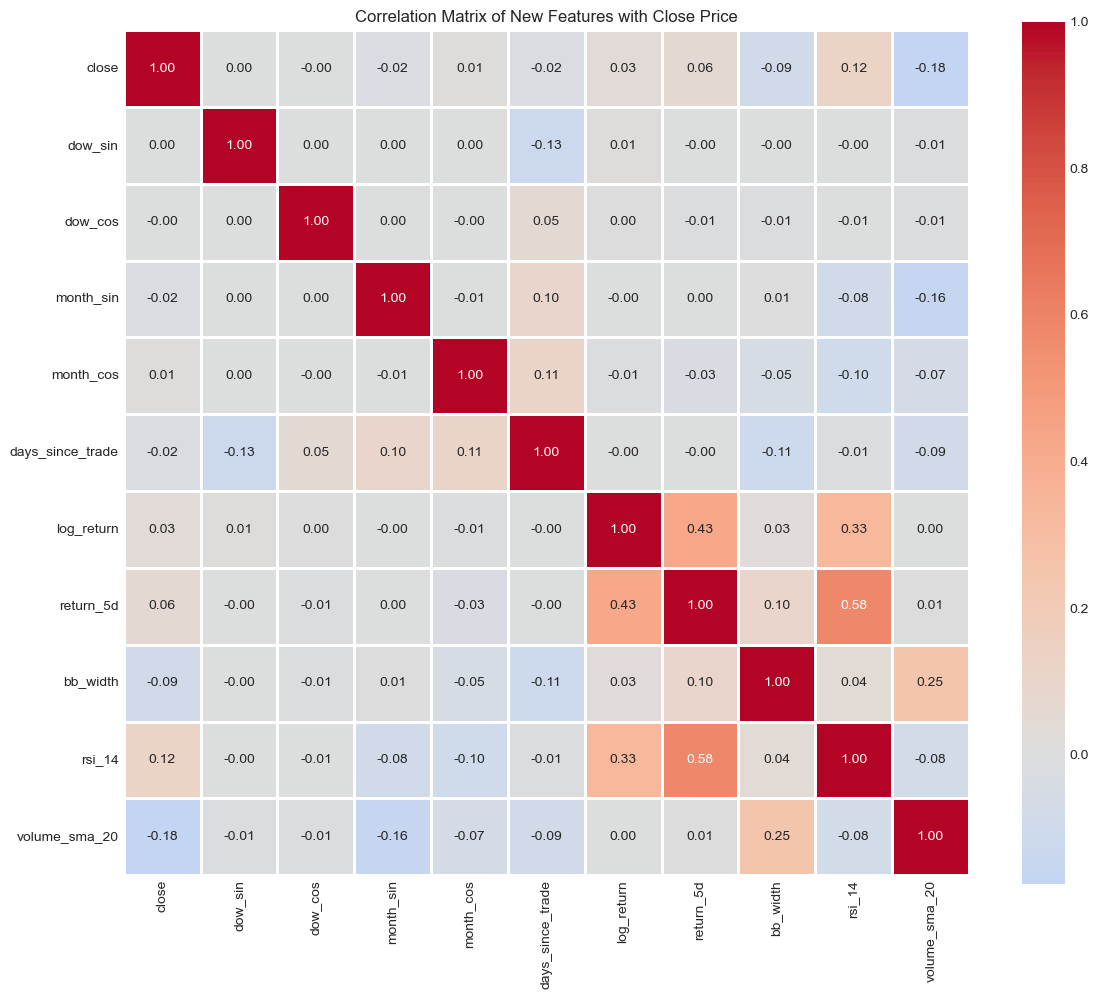

In [10]:
# Correlation matrix for new features + close price
corr_features = ['close'] + new_features
corr_matrix = hbea_advanced[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix of New Features with Close Price')
plt.tight_layout()
plt.show()

## 10. Time Series Visualization

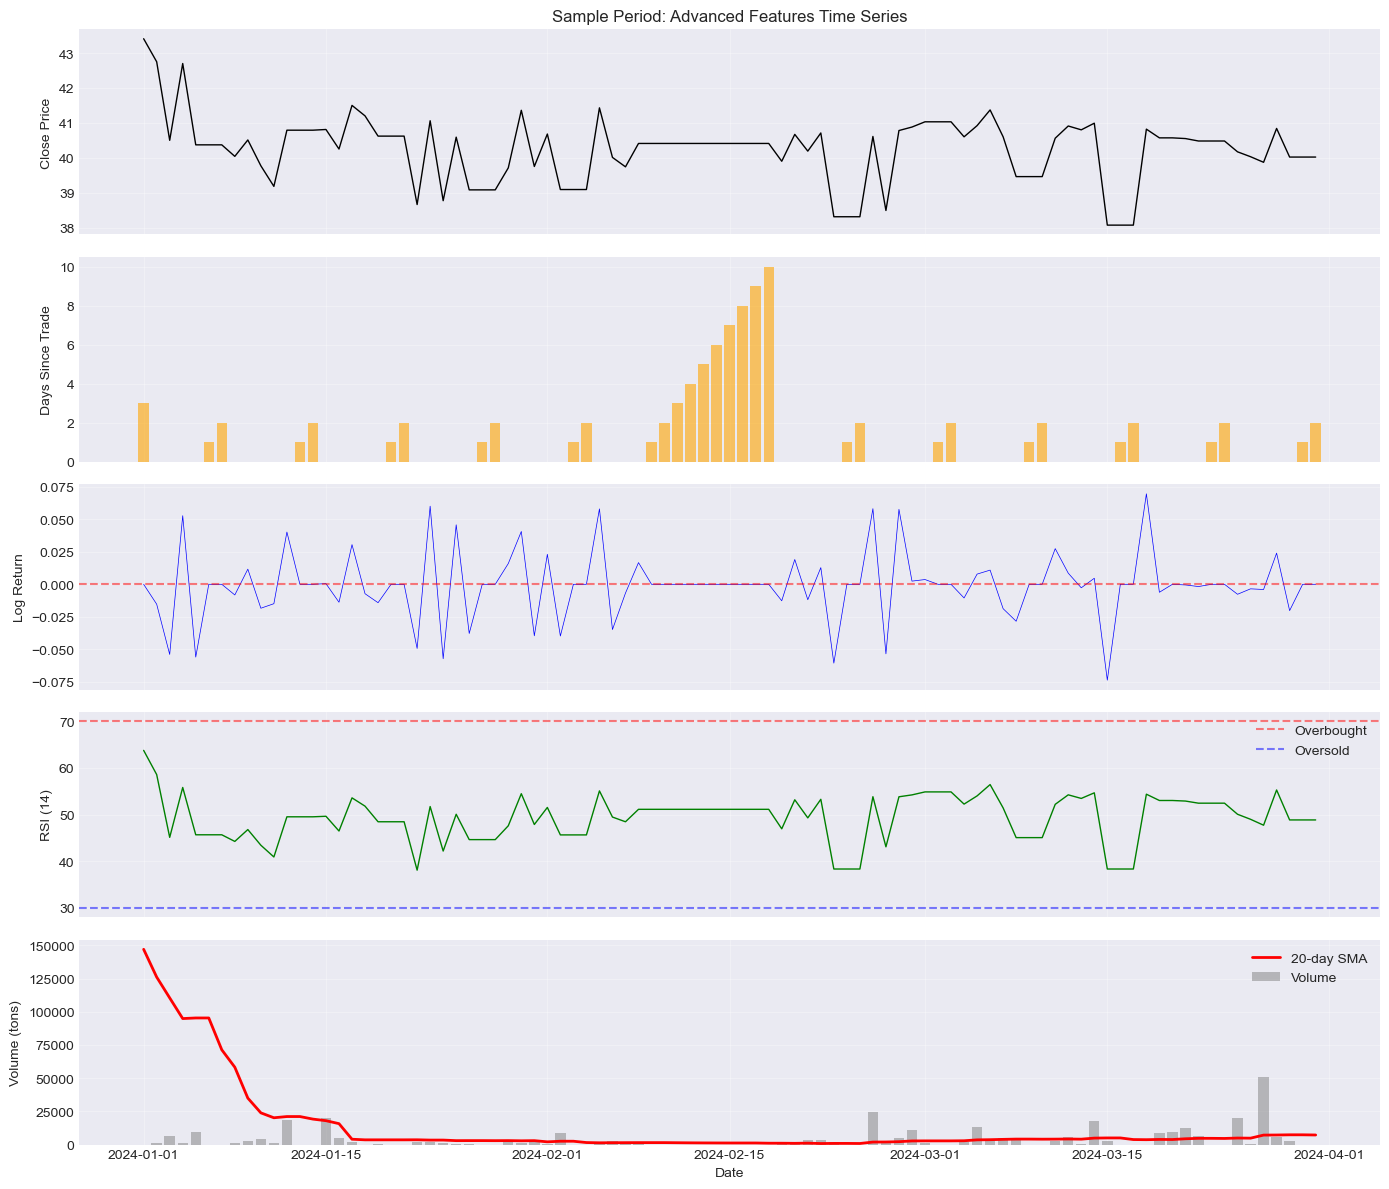

In [11]:
# Sample 3-month period for visualization
sample_start = '2024-01-01'
sample_end = '2024-03-31'
sample_data = hbea_advanced.loc[sample_start:sample_end]

if len(sample_data) > 0:
    fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)
    
    # Close price
    axes[0].plot(sample_data.index, sample_data['close'], color='black', linewidth=1)
    axes[0].set_ylabel('Close Price')
    axes[0].set_title('Sample Period: Advanced Features Time Series')
    axes[0].grid(True, alpha=0.3)
    
    # Days since trade
    axes[1].bar(sample_data.index, sample_data['days_since_trade'], 
                color='orange', alpha=0.6)
    axes[1].set_ylabel('Days Since Trade')
    axes[1].grid(True, alpha=0.3)
    
    # Log returns
    axes[2].plot(sample_data.index, sample_data['log_return'], 
                 color='blue', linewidth=0.5)
    axes[2].set_ylabel('Log Return')
    axes[2].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[2].grid(True, alpha=0.3)
    
    # RSI
    axes[3].plot(sample_data.index, sample_data['rsi_14'], 
                 color='green', linewidth=1)
    axes[3].axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought')
    axes[3].axhline(30, color='blue', linestyle='--', alpha=0.5, label='Oversold')
    axes[3].set_ylabel('RSI (14)')
    axes[3].legend(loc='upper right')
    axes[3].grid(True, alpha=0.3)
    
    # Volume
    axes[4].bar(sample_data.index, sample_data['volume_tons'], 
                color='gray', alpha=0.5, label='Volume')
    axes[4].plot(sample_data.index, sample_data['volume_sma_20'], 
                 color='red', linewidth=2, label='20-day SMA')
    axes[4].set_ylabel('Volume (tons)')
    axes[4].set_xlabel('Date')
    axes[4].legend(loc='upper right')
    axes[4].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No data available for period {sample_start} to {sample_end}")

## 11. Save Advanced LSTM Data

In [12]:
# Save the enhanced datasets
output_dir = os.path.join("../../02_Data_Processed/03_Feature_Engineered/")

hbea_output_path = os.path.join(output_dir, "HBEA_LSTM_advanced.parquet")
gdea_output_path = os.path.join(output_dir, "GDEA_LSTM_advanced.parquet")

hbea_advanced.to_parquet(hbea_output_path)
gdea_advanced.to_parquet(gdea_output_path)

print(f"Saved HBEA advanced LSTM data: {hbea_output_path}")
print(f"Shape: {hbea_advanced.shape}")
print(f"\nSaved GDEA advanced LSTM data: {gdea_output_path}")
print(f"Shape: {gdea_advanced.shape}")

Saved HBEA advanced LSTM data: ../../02_Data_Processed/03_Feature_Engineered/HBEA_LSTM_advanced.parquet
Shape: (4027, 52)

Saved GDEA advanced LSTM data: ../../02_Data_Processed/03_Feature_Engineered/GDEA_LSTM_advanced.parquet
Shape: (3967, 52)


## 12. Final Summary

In [13]:
print("=" * 60)
print("LSTM ADVANCED FEATURE ENGINEERING COMPLETE")
print("=" * 60)

print(f"\nOriginal features: {hbea_df.shape[1]}")
print(f"New features added: {len(new_features)}")
print(f"Total features: {hbea_advanced.shape[1]}")

print("\nFeature Categories:")
print("  1. Cyclical Time (4): dow_sin, dow_cos, month_sin, month_cos")
print("  2. Market State (1): days_since_trade")
print("  3. Returns (2): log_return, return_5d")
print("  4. Volatility (1): bb_width")
print("  5. Momentum (1): rsi_14")
print("  6. Volume (1): volume_sma_20")

print("\nKey Statistics:")
print(f"  - Trading days: {(hbea_advanced['has_trade'] == True).sum()}")
print(f"  - Non-trading days: {(hbea_advanced['has_trade'] == False).sum()}")
print(f"  - Max consecutive non-trading days: {hbea_advanced['days_since_trade'].max()}")
print(f"  - Average RSI: {hbea_advanced['rsi_14'].mean():.2f}")
print(f"  - Average daily log return: {hbea_advanced['log_return'].mean():.6f}")

# Show all column names
print("\nAll columns (52 total):")
for i, col in enumerate(hbea_advanced.columns, 1):
    print(f"  {i:2d}. {col}")

LSTM ADVANCED FEATURE ENGINEERING COMPLETE

Original features: 42
New features added: 10
Total features: 52

Feature Categories:
  1. Cyclical Time (4): dow_sin, dow_cos, month_sin, month_cos
  2. Market State (1): days_since_trade
  3. Returns (2): log_return, return_5d
  4. Volatility (1): bb_width
  5. Momentum (1): rsi_14
  6. Volume (1): volume_sma_20

Key Statistics:
  - Trading days: 2610
  - Non-trading days: 1417
  - Max consecutive non-trading days: 59
  - Average RSI: 50.34
  - Average daily log return: 0.000128

All columns (52 total):
   1. close
   2. vwap
   3. volume_tons
   4. turnover_cny
   5. cum_turnover_cny
   6. is_open
   7. is_quiet
   8. has_trade
   9. Hubei_ElectricityConsumption_Monthly_ffill_daily_15
  10. Hubei_IndustrialAddedValue_RealPrices_AboveScaleIndustry_YoY_ffill_daily_15
  11. Hubei_GDP_Cumulative_ffill_daily_15
  12. China_Output_CrudeOilProcessing_Monthly_ffill_daily_15
  13. FuturesSettle(Cont)_BrentCrude_ffill_daily_1
  14. FuturesClose(Cont)